In [1]:
# A combined cohort of TCGA, TARGET and GTEx samples
# https://xenabrowser.net/datapages/?cohort=TCGA%20TARGET%20GTEx
# Unifying cancer and normal RNA sequencing data from different sources
# https://www.nature.com/articles/sdata201861

In [2]:
import warnings; warnings.filterwarnings("ignore") 

In [3]:
import time; start = time.time()

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
#!conda install -c conda-forge statsmodels

In [6]:
import warnings; warnings.filterwarnings("ignore")
from scipy.stats import mannwhitneyu, normaltest 
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statannotations.Annotator import Annotator 
from statannot import add_stat_annotation 
import matplotlib.pyplot as plt
#import autogrod.numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np 

In [7]:
GenesOfInterest = ["HEPACAM2","POLA2","KCNJ3","PPP4R3B","GID8"]

In [8]:
#metadata_link    = "https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TcgaTargetGtex_expected_count.json"
#data_link       = "https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TcgaTargetGtex_expected_count.gz"
#data_link       = "https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TcgaTargetGtex_rsem_gene_tpm.gz"
genes_link      = "https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&col=md_ensembl_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit"
phenotype_link  = "https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/TcgaTargetGTEX_phenotype.txt.gz"
data_link       = "./data/TcgaTargetGtex_rsem_gene_tpm.gz"

In [9]:
#metadata = pd.read_csv(metadata_link, compression="gzip", header=0, sep="\t", quotechar='"', error_bad_lines=False)
genes     = pd.read_csv(genes_link, header=0, sep="\t", quotechar='"', error_bad_lines=False, encoding="latin-1")
phenotype = pd.read_csv(phenotype_link, compression="gzip", header=0, sep="\t", quotechar='"', error_bad_lines=False, encoding="latin-1")

In [10]:
columns={"Ensembl ID(supplied by Ensembl)":"EnsemblGeneID","Approved symbol":"GeneSymbol"}
genes.rename(columns=columns, inplace=True)
print(len(genes)); genes.sample(3)

48669


,GeneSymbol,EnsemblGeneID
9016,EID2B,ENSG00000176401
18709,LINC02123,ENSG00000250668
38228,RPS27P30,NaN


In [11]:
# print(len(phenotype)); phenotype.sample(3)

In [12]:
chunk_size = 10
chunk_no = 1
GoI_found = 0
chunks = pd.DataFrame()

In [13]:
%%time
for chunk in tqdm(pd.read_csv(data_link, compression='gzip', sep='\t', chunksize = chunk_size), colour="green"):
    chunk.rename(columns={"sample":"EnsemblGeneID"}, inplace=True)
    chunk.EnsemblGeneID = chunk.EnsemblGeneID.str.slice(0,15)
    df = pd.merge(chunk, genes, on = "EnsemblGeneID", how = "left")
    df.drop(["EnsemblGeneID"], axis=1, inplace=True)
    df.insert(0,"GeneSymbol", df.pop("GeneSymbol"))
    chunk = df.loc[df["GeneSymbol"].isin(GenesOfInterest)]
    chunks = pd.concat([chunks, chunk], ignore_index=True)
    #print(df.sample(3))
    #print(chunk.sample(len(chunk)))
    print(len(chunks), " 'Genes of Interest' have been found so far ...")
    if chunk_no == len(GenesOfInterest):
        #print("All " + str(len(GenesOfInterest)) + " 'Genes of Interest' have been found!!!")
        print("All 'Genes of Interest' have been found!!!")
        break
    chunk_no += 1

1it [00:00,  1.05it/s]

2  'Genes of Interest' have been found so far ...


2it [00:01,  1.12it/s]

2  'Genes of Interest' have been found so far ...


3it [00:02,  1.13it/s]

3  'Genes of Interest' have been found so far ...


4it [00:03,  1.12it/s]

5  'Genes of Interest' have been found so far ...
CPU times: total: 3.61 s
Wall time: 3.61 s


In [14]:
df = pd.melt(chunks, id_vars=["GeneSymbol"], var_name = "SampleID", value_name ="TPM")
df = df[df["GeneSymbol"].notna()]
print(df.sample(3))

      GeneSymbol                 SampleID     TPM
15560   HEPACAM2          TCGA-G9-6348-01 -1.2828
46652      POLA2  GTEX-XXEK-0326-SM-4BRVV  3.2389
18626       GID8          TCGA-EJ-7328-11  4.1203


In [15]:
phenotype.columns.tolist()

['sample',
 'detailed_category',
 'primary disease or tissue',
 '_primary_site',
 '_sample_type',
 '_gender',
 '_study']

In [16]:
columns={"sample":"SampleID", "detailed_category":"DetailedCategory","_primary_site":"PrimarySite",
         "_sample_type":"SampleType","_study":"Study","_gender":"Gender"}
phenotype.rename(columns=columns, inplace=True)

In [17]:
SelectedSampleTypes = ["Primary Tumor","Normal Tissue","Primary Solid Tumor"]
phenotype = phenotype[phenotype.SampleType.isin(SelectedSampleTypes)]

In [18]:
print(len(phenotype)); phenotype.sample(3)

16900


,SampleID,DetailedCategory,primary disease or tissue,PrimarySite,SampleType,Gender,Study
14392,GTEX-12696-1726-SM-5EQLH,Stomach,Stomach,Stomach,Normal Tissue,Male,GTEX
8688,TCGA-D8-A1X8-01,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Breast,Primary Tumor,Female,TCGA
6851,TCGA-CV-A45X-01,Head & Neck Squamous Cell Carcinoma,Head & Neck Squamous Cell Carcinoma,Head and Neck region,Primary Tumor,Male,TCGA


In [19]:
def function(row):
    if row["SampleType"] == "Primary Tumor":
        return "Tumor"
    elif row["SampleType"] == "Solid Tissue Normal":
        return "Healthy"        
    elif row["SampleType"] == "Normal Tissue":
        return "Healthy"
    else:
        return "NaN"

In [20]:
phenotype["SampleType2"] = phenotype.apply(function, axis=1)

In [21]:
print(len(phenotype)); phenotype.sample(3)

16900


,SampleID,DetailedCategory,primary disease or tissue,PrimarySite,SampleType,Gender,Study,SampleType2
12130,GTEX-OHPM-0006-SM-2HMKU,Whole Blood,Whole Blood,Blood,Normal Tissue,Male,GTEX,Healthy
11438,GTEX-XMD1-0011-R2B-SM-4AT5N,Brain - Substantia Nigra,Brain - Substantia Nigra,Brain,Normal Tissue,Male,GTEX,Healthy
8870,TCGA-AQ-A7U7-01,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Breast,Primary Tumor,Female,TCGA,Tumor


In [22]:
SelectedPrimarySiteTypes = ["Brain","Breast","Spleen","Testis"]
phenotype = phenotype[phenotype["PrimarySite"].isin(SelectedPrimarySiteTypes)]

In [23]:
PrimarySiteTypes = phenotype.PrimarySite.unique().tolist(); print(PrimarySiteTypes)

['Testis', 'Brain', 'Breast', 'Spleen']


In [24]:
columns=["SampleID", "SampleType", "SampleType2", "Study", "PrimarySite", "DetailedCategory"]
phenotype = phenotype[columns].copy()
print(len(phenotype)); phenotype.sample(3)

3498


,SampleID,SampleType,SampleType2,Study,PrimarySite,DetailedCategory
11083,GTEX-13112-0011-R5b-SM-5DUV8,Normal Tissue,Healthy,GTEX,Brain,Brain - Caudate (Basal Ganglia)
15329,GTEX-14DAR-0326-SM-5S2PS,Normal Tissue,Healthy,GTEX,Spleen,Spleen
13671,GTEX-ZVTK-0126-SM-57WDG,Normal Tissue,Healthy,GTEX,Testis,Testis


In [25]:
df = pd.merge(phenotype, df, on = "SampleID", how = "left")

In [26]:
columns=["SampleType", "SampleType2", "PrimarySite", "Study", "GeneSymbol", "TPM"]
df1 = df[columns]; df1.sample(3)

,SampleType,SampleType2,PrimarySite,Study,GeneSymbol,TPM
2723,Primary Tumor,Tumor,Breast,TCGA,KCNJ3,5.5088
7635,Primary Tumor,Tumor,Brain,TCGA,HEPACAM2,-0.8863
6464,Primary Tumor,Tumor,Breast,TCGA,PPP4R3B,5.3259


In [27]:
df1 = df1[df1.GeneSymbol.notna()]; df1.GeneSymbol.isna().sum()

0

In [28]:
PrimarySiteList = sorted(df1.PrimarySite.unique().tolist()); print(PrimarySiteList)

['Brain', 'Breast', 'Spleen', 'Testis']


In [29]:
GenesOfInterest = sorted(df1.GeneSymbol.unique().tolist()); print(GenesOfInterest)

['GID8', 'HEPACAM2', 'KCNJ3', 'POLA2', 'PPP4R3B']


In [30]:
SampleTypePalette = [(0.21, 0.68, 0.64), (0.97, 0.44, 0.54)]
SampleTypePalette

[(0.21, 0.68, 0.64), (0.97, 0.44, 0.54)]

In [31]:
SampleOrder = ["Healthy", "Tumor"]

In [32]:
Pairs = [(('Breast',"Healthy"),('Breast',"Tumor")), (('Brain',"Healthy"),('Brain',"Tumor"))]
annot_params = {"test": "Mann-Whitney"}

Mann-Whitney-Wilcoxon test two-sided
M.W.W.
7.04e+05
2.88e-198

StatResult attributes: dict_keys(['test_description', 'test_short_name', 'stat_str', 'stat_value', 'pvalue', '_corrected_significance', '_correction_method', 'alpha', 'group1', 'group2'])
Mann-Whitney-Wilcoxon test two-sided
M.W.W.
1.84e+05
1.10e-79

StatResult attributes: dict_keys(['test_description', 'test_short_name', 'stat_str', 'stat_value', 'pvalue', '_corrected_significance', '_correction_method', 'alpha', 'group1', 'group2'])
Mann-Whitney-Wilcoxon test two-sided
M.W.W.
5.14e+05
3.99e-35

StatResult attributes: dict_keys(['test_description', 'test_short_name', 'stat_str', 'stat_value', 'pvalue', '_corrected_significance', '_correction_method', 'alpha', 'group1', 'group2'])
Mann-Whitney-Wilcoxon test two-sided
M.W.W.
1.03e+05
2.61e-01

StatResult attributes: dict_keys(['test_description', 'test_short_name', 'stat_str', 'stat_value', 'pvalue', '_corrected_significance', '_correction_method', 'alpha', 'group1', 'group

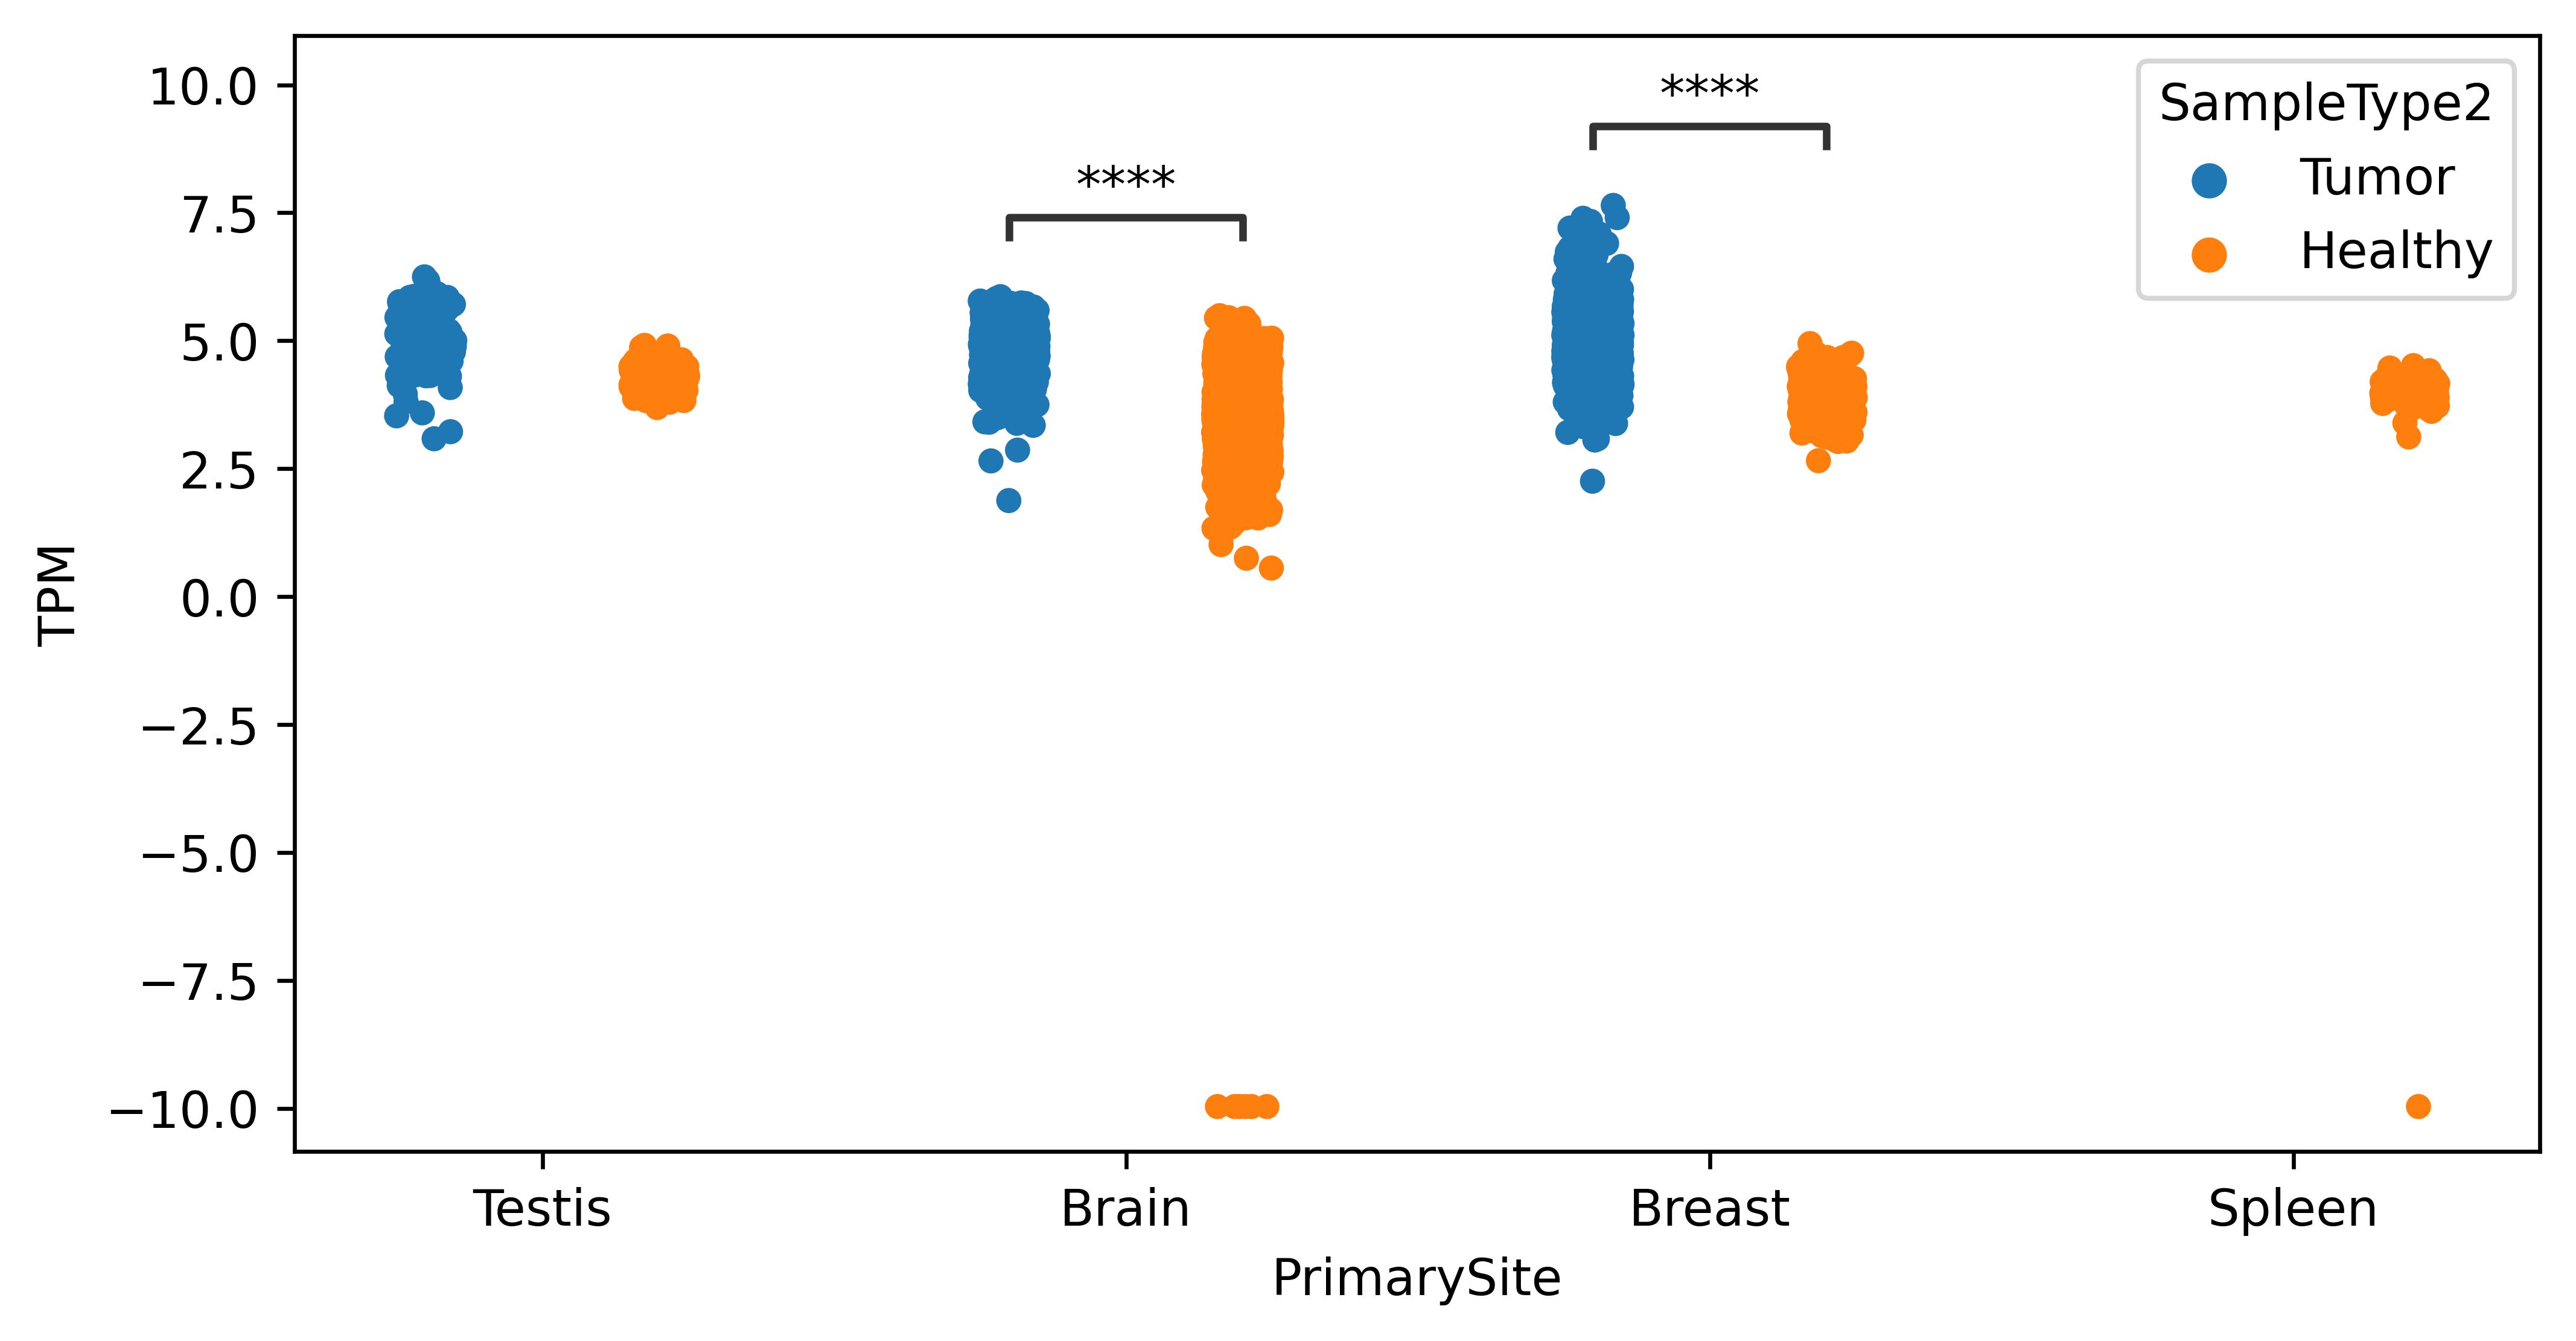

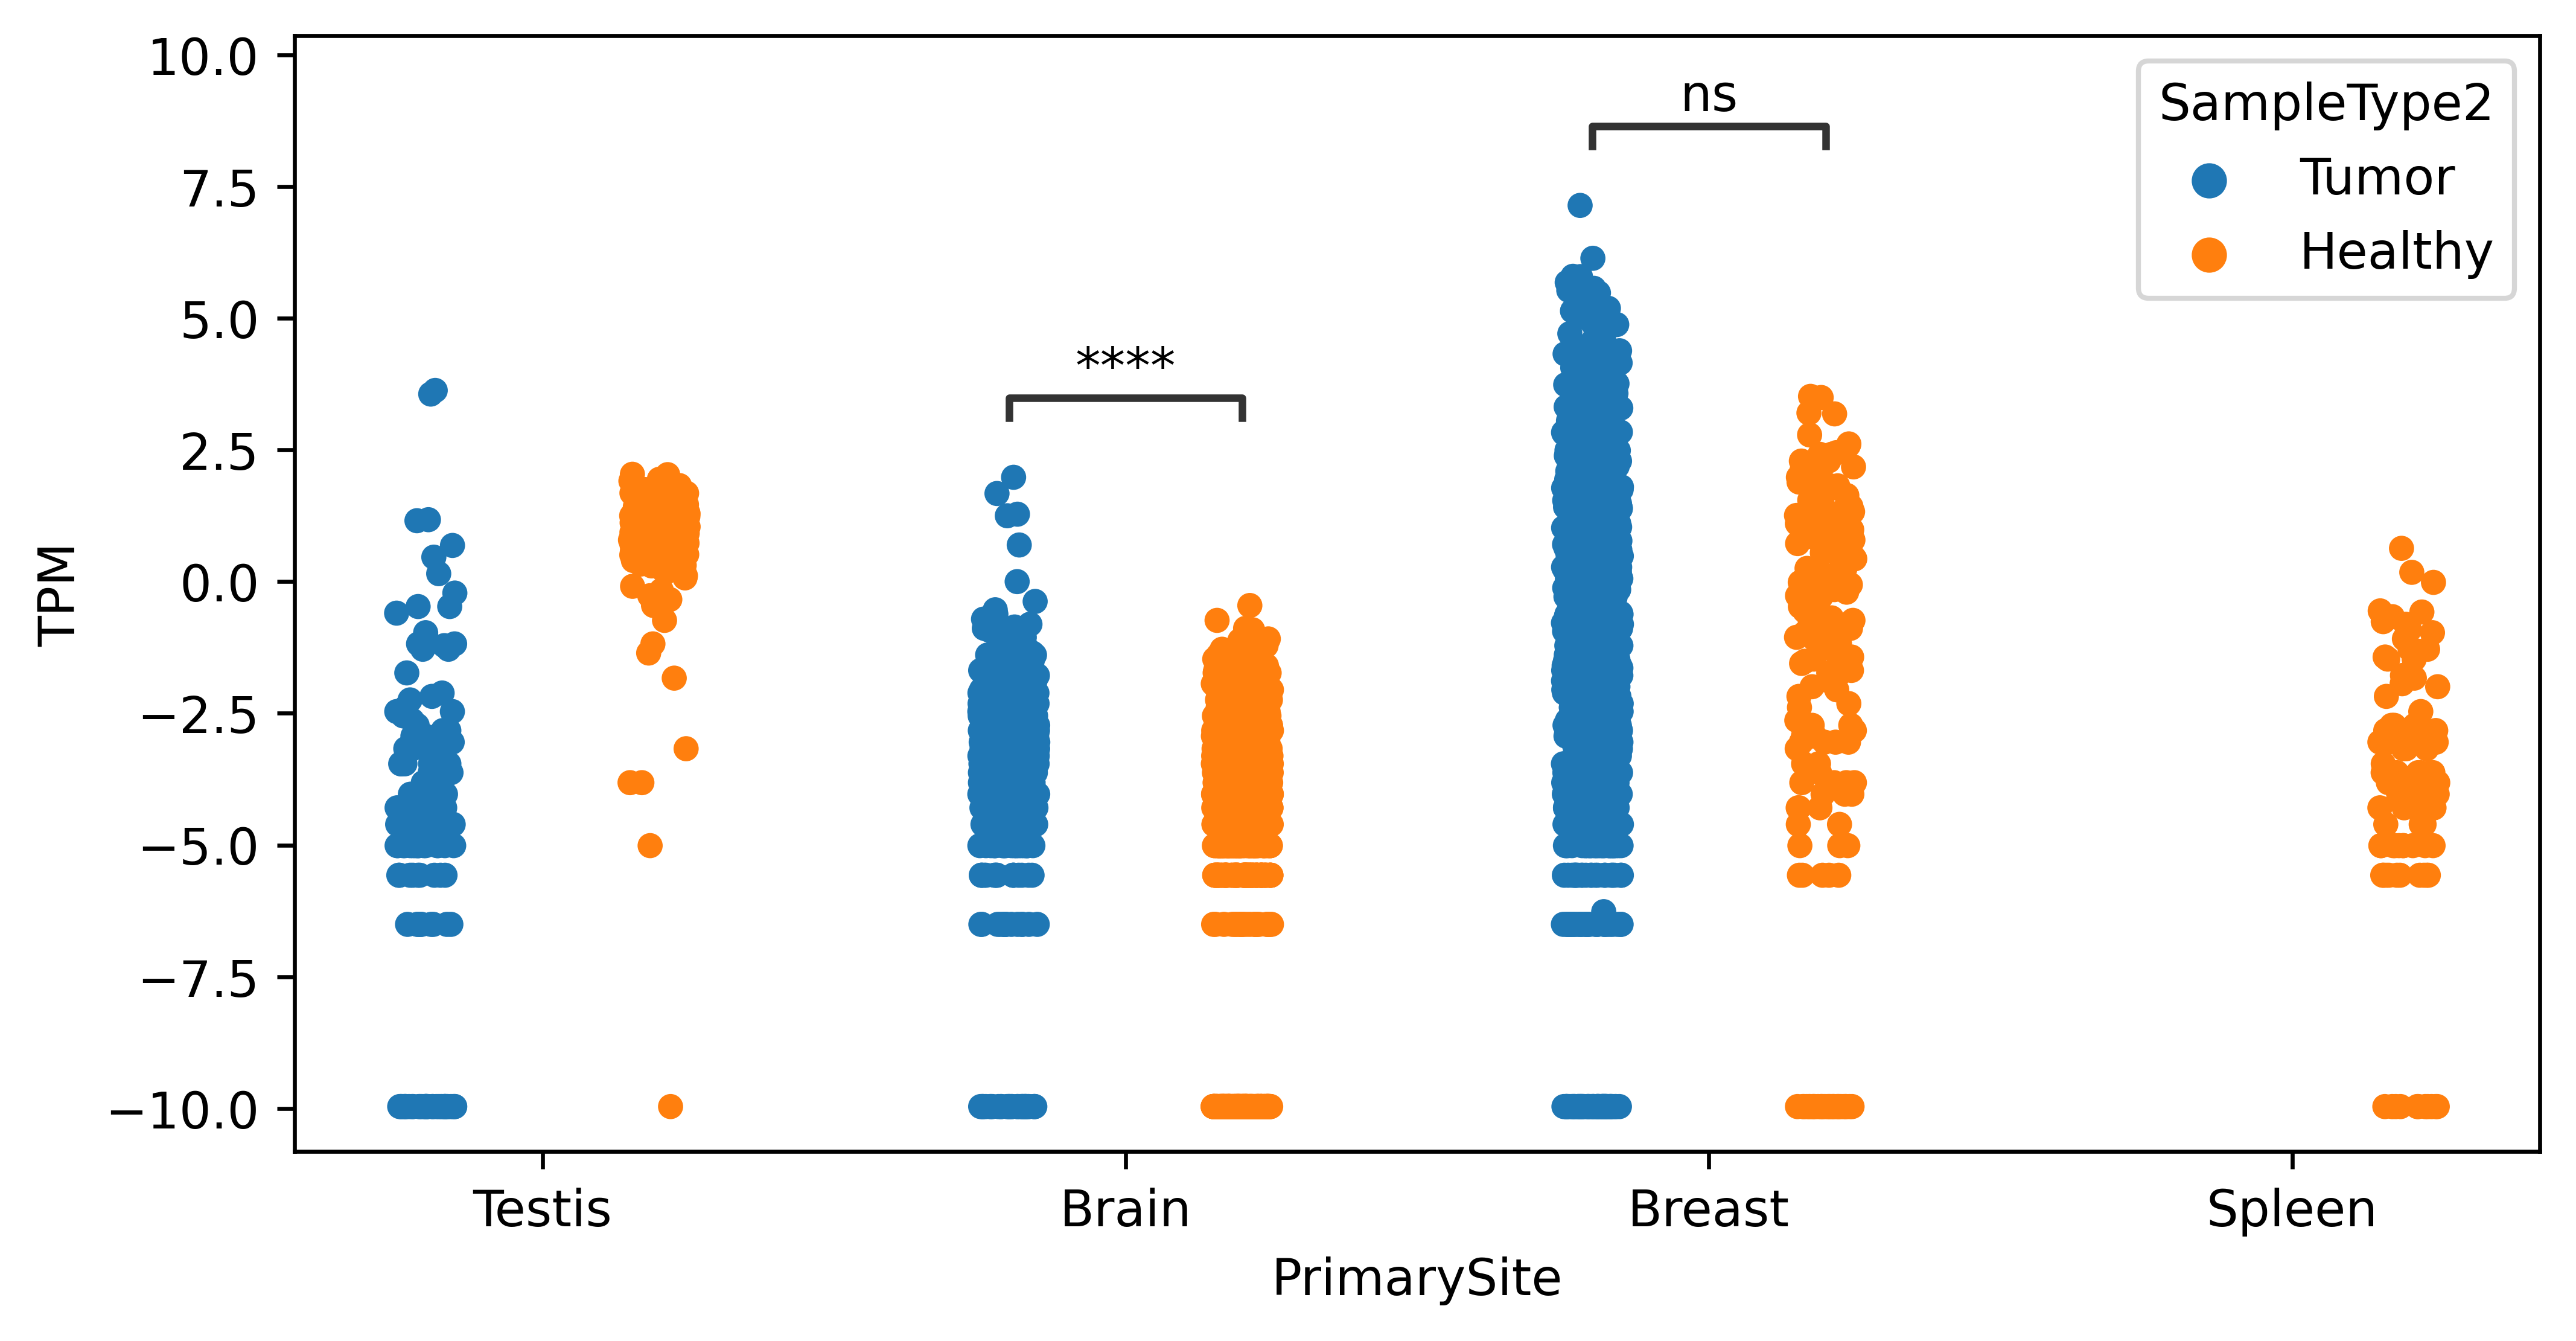

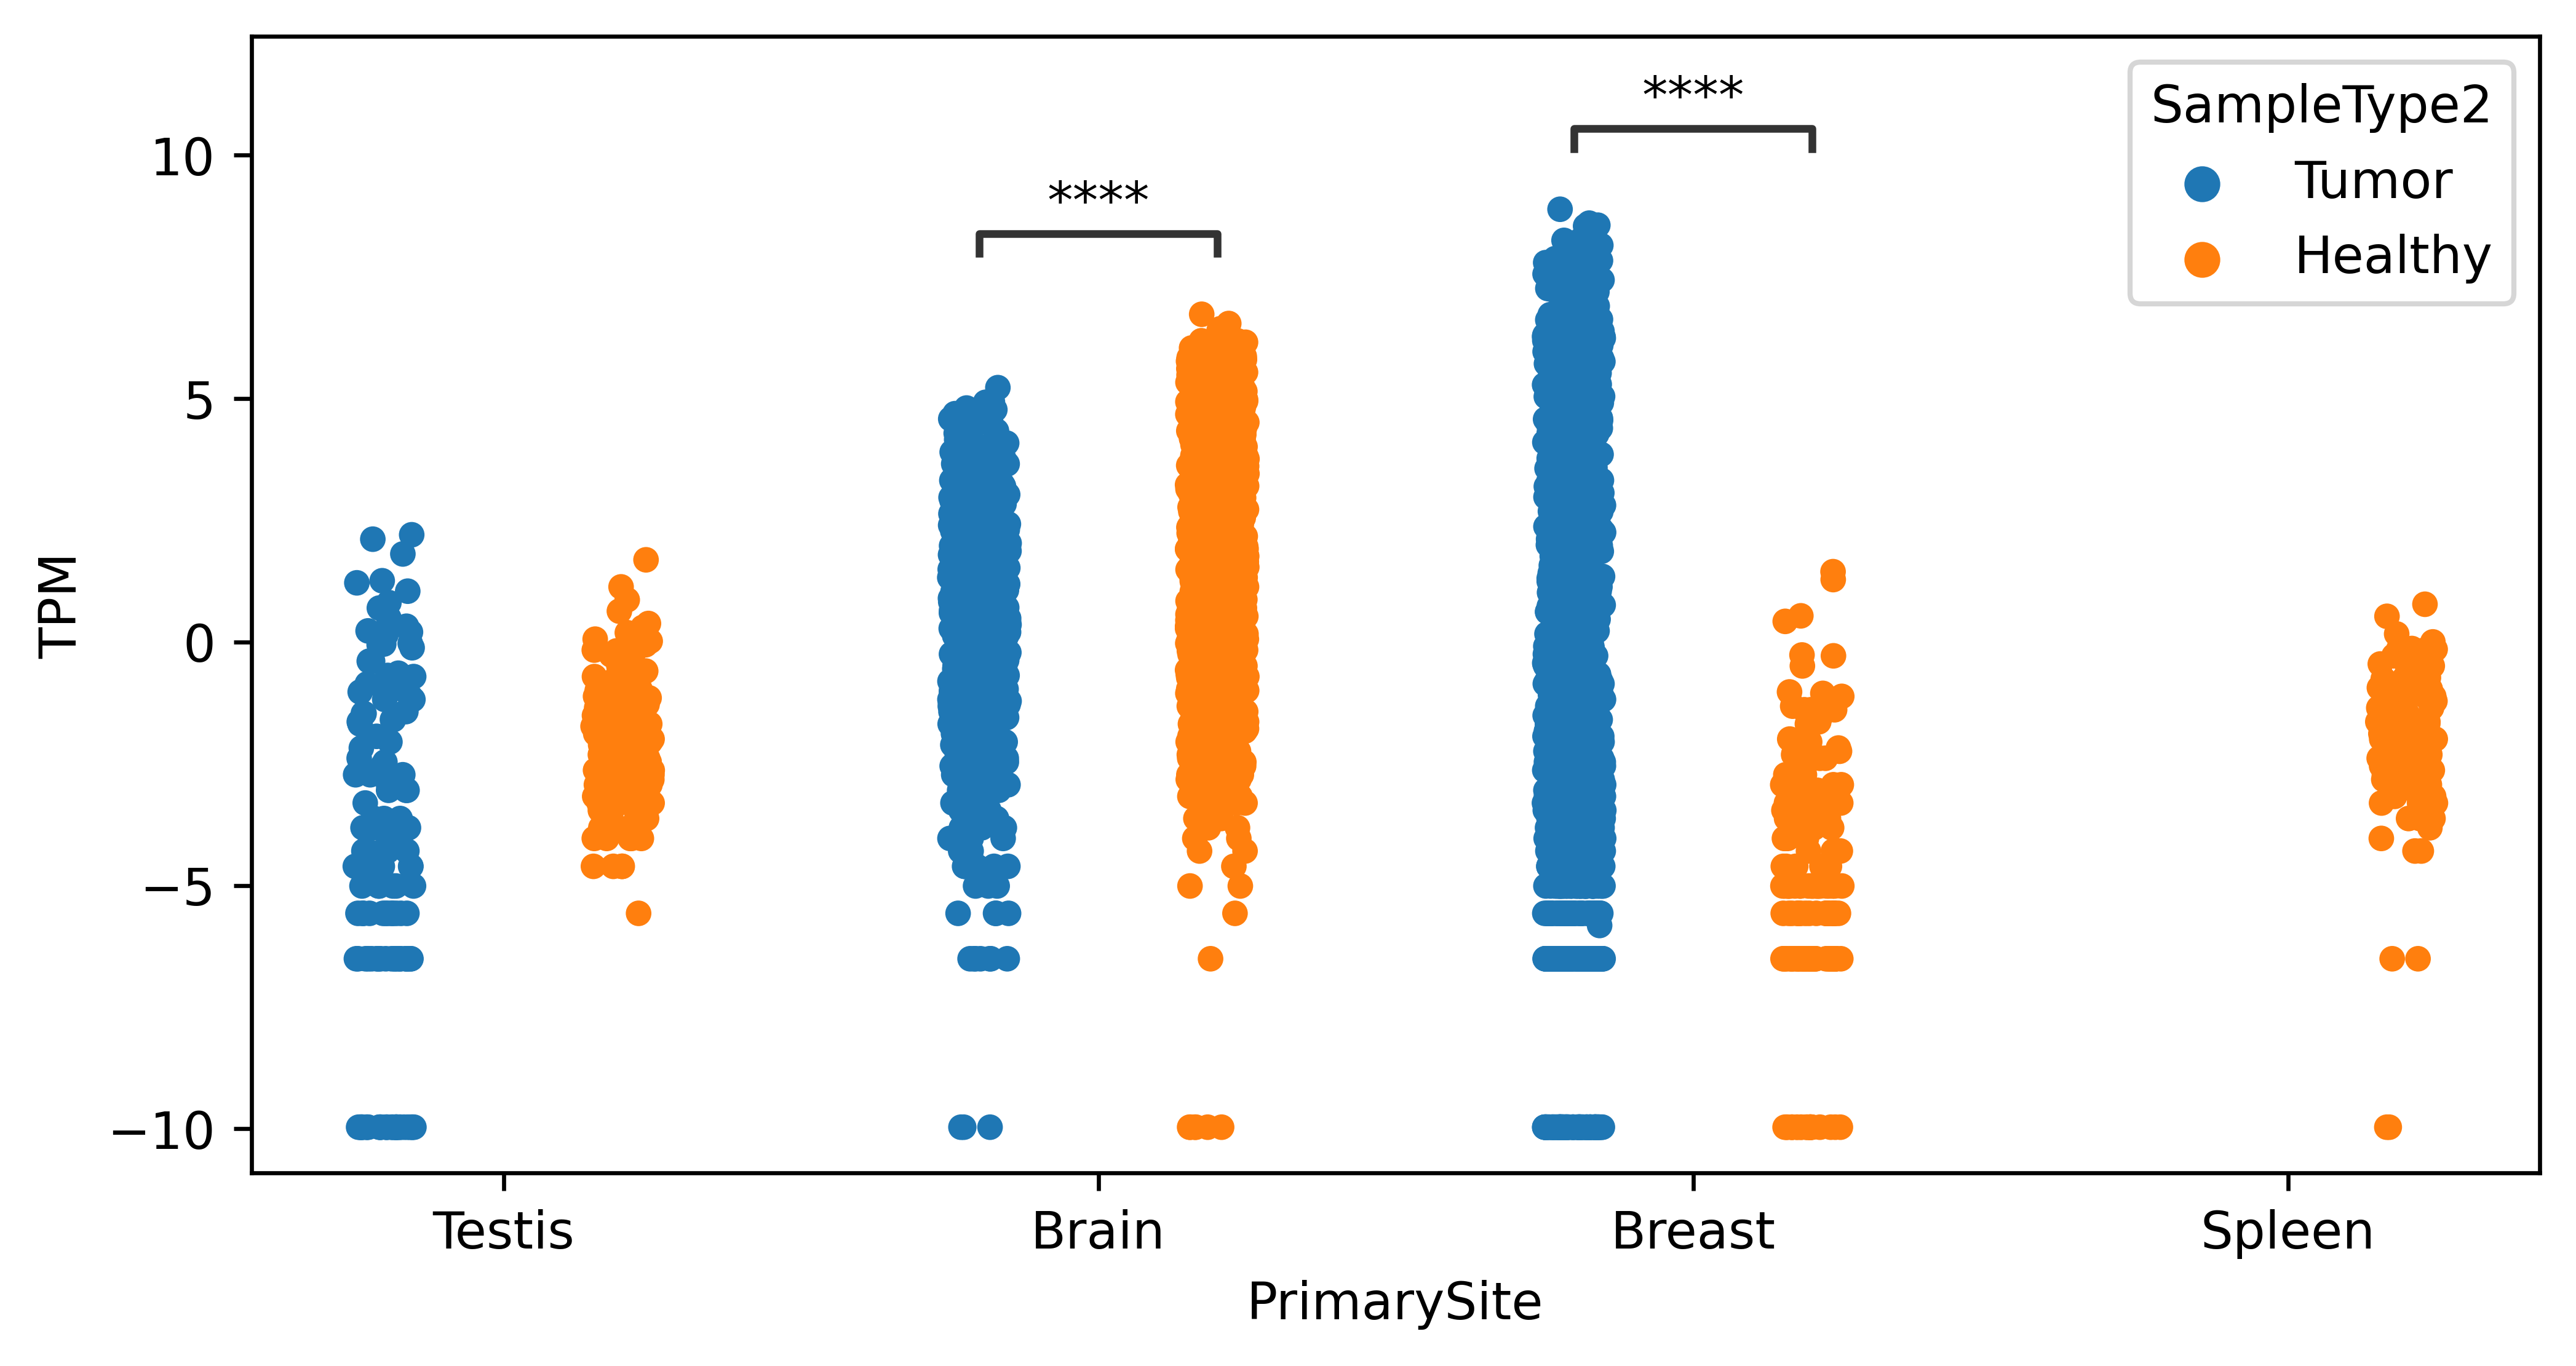

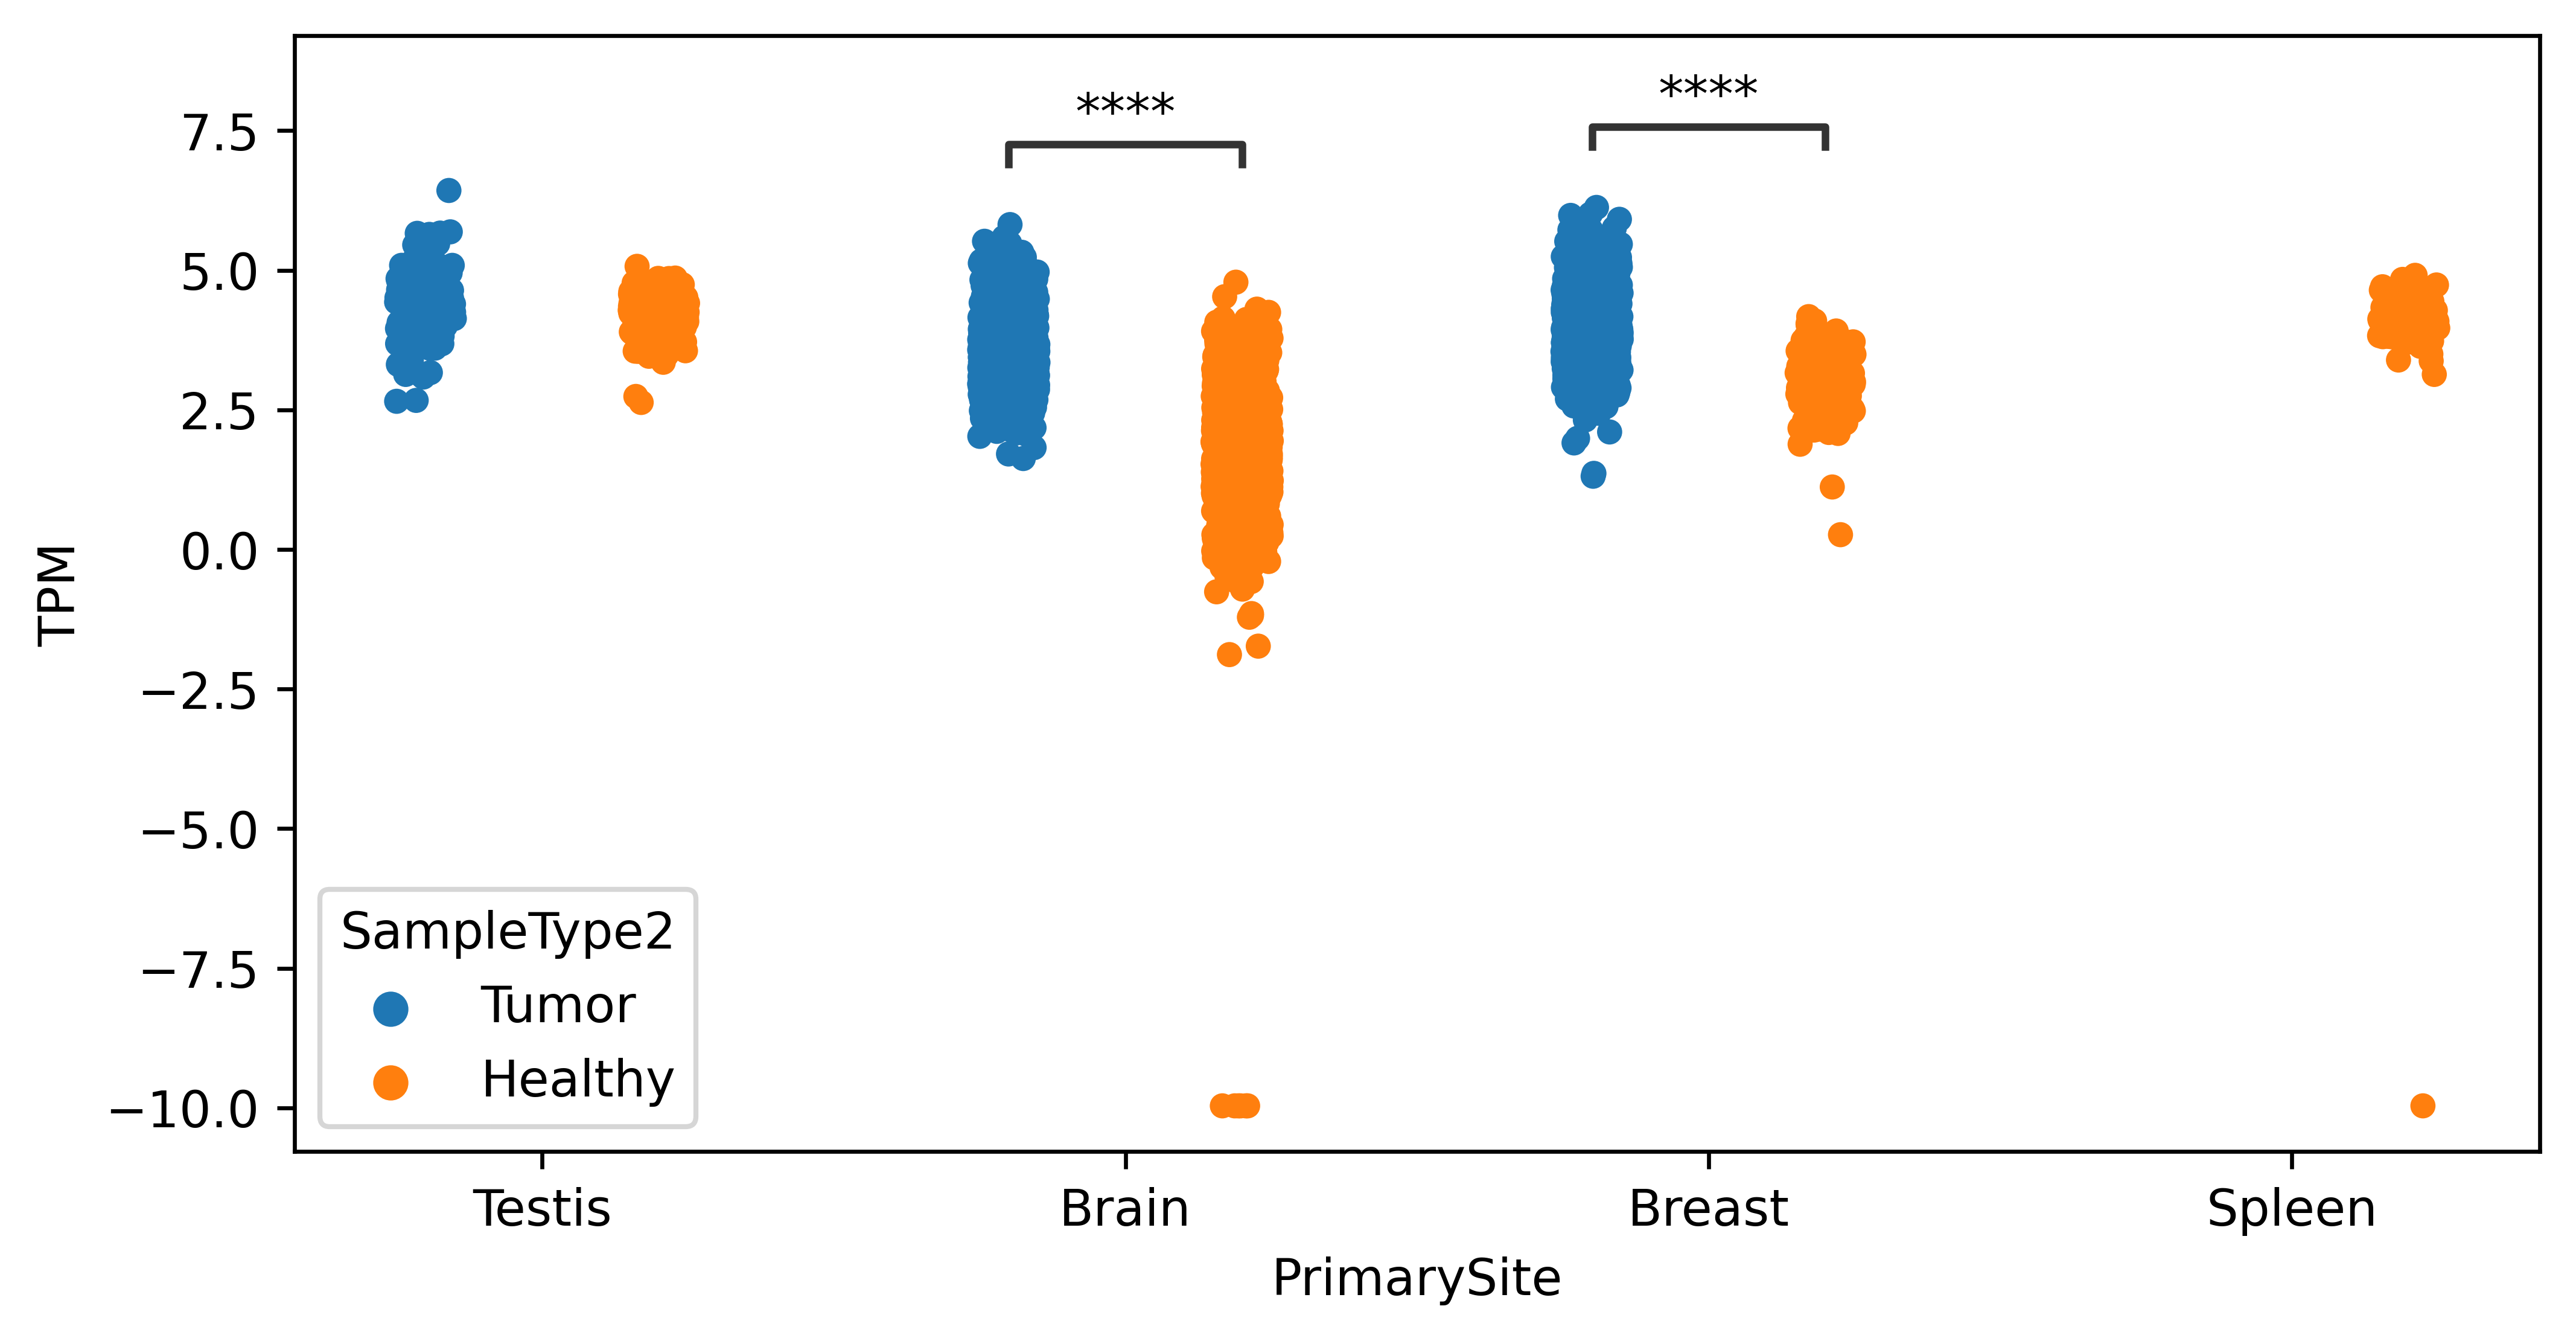

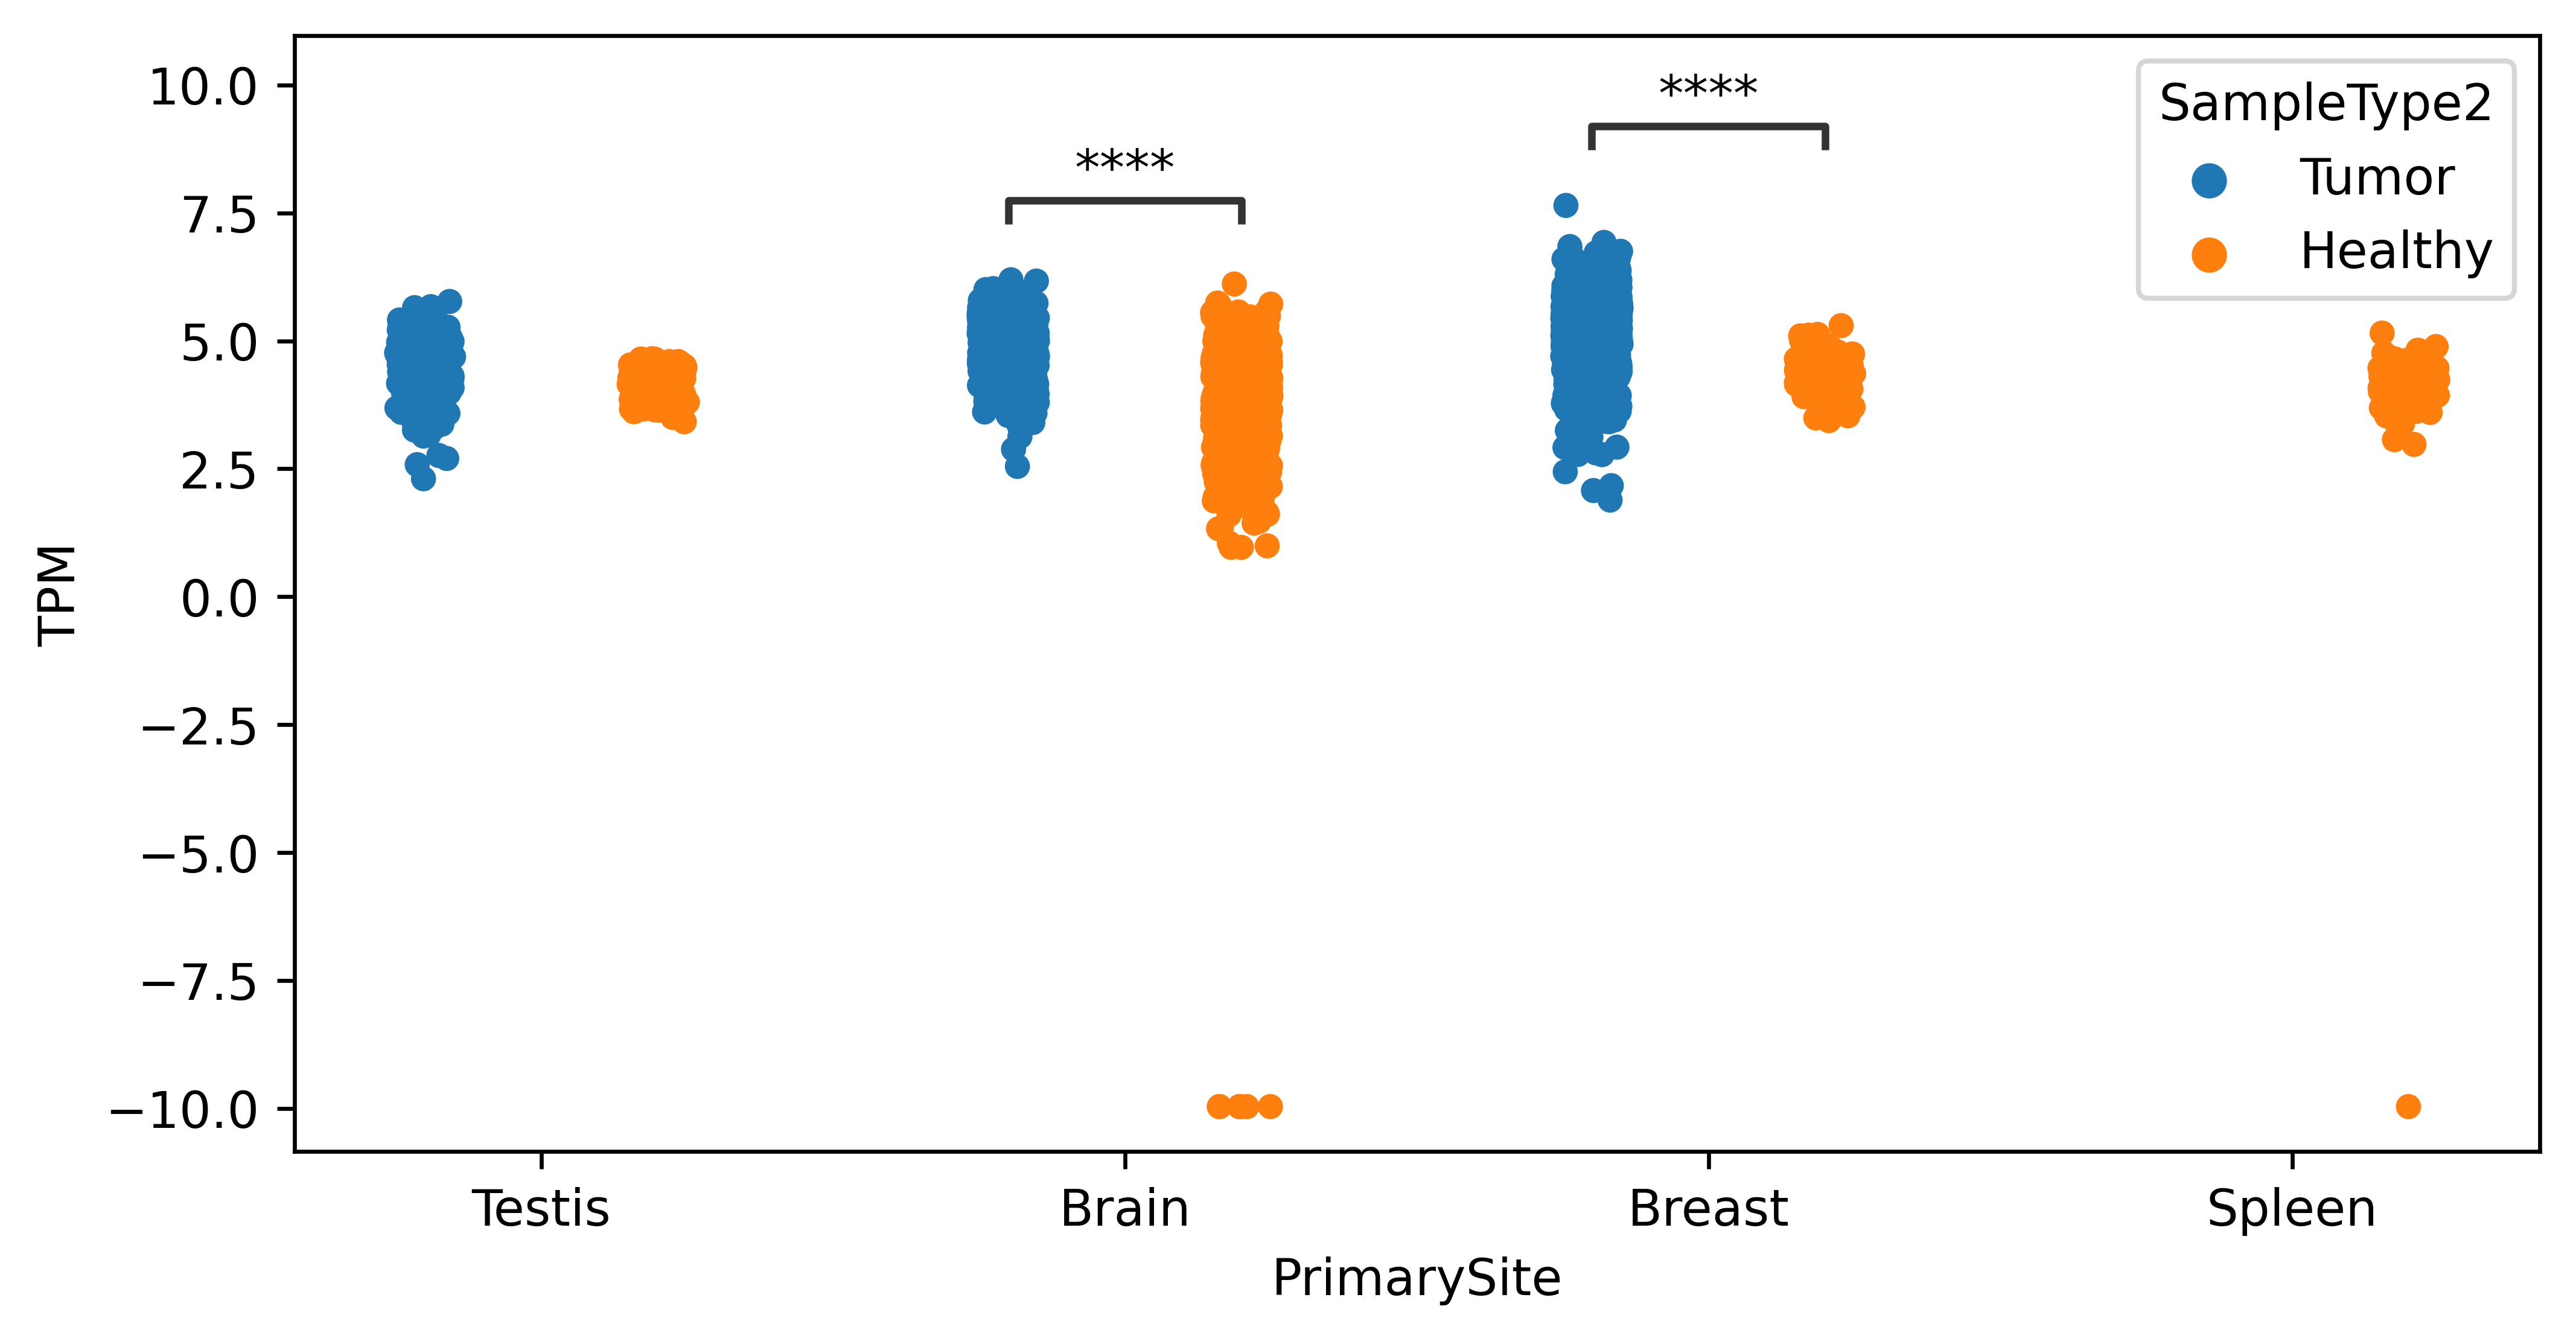

In [65]:
%%time
for gene in sorted(GenesOfInterest):
    fig, ax = plt.subplots(figsize=(8,4), dpi = 300)
    df2 = df1.loc[df1.GeneSymbol == gene]
    ax = sns.stripplot(ax=ax, data=df2, x = "PrimarySite", y="TPM", dodge=True, hue="SampleType2")
    
    annotator = Annotator(ax, pairs=Pairs, data =df2, x = "PrimarySite", y="TPM", hue="SampleType2")
    results = annotator.reset_configuration().configure(**annot_params, verbose=False)
    #nnotator.apply_and_annotate()
    ax, test_results = annotator.apply_and_annotate()
    for res in test_results:
        print(res.data.test_description)
        print(res.data.test_short_name)
        print(f"{res.data.stat_value:.2e}")
        print(f"{res.data.pvalue:.2e}")
        print("\nStatResult attributes:", test_results[0].data.__dict__.keys())
        #print(test_results)

        
        

In [34]:
"StatResult attributes: dict_keys(['test_description', 'test_short_name', 'stat_str', 'stat_value', 'pvalue',
'_corrected_significance', '_correction_method', 'alpha', 'group1', 'group2'])"

SyntaxError: EOL while scanning string literal (599076823.py, line 1)

In [ ]:
=   =   =   =   S  T  O  P   =   =   =   = 

In [ ]:
print("'DataExploration_v003' script run time:", f'{time.time()-start:.0f}', "seconds.")

In [ ]:
    
    chunk = chunk[chunk['Description'].isin(GoI)]
    chunks = pd.concat([chunks, chunk], ignore_index=True)
    GoI_found += len(chunk)
    print("\n", GoI_found, "Genes of Interest found so far\n")
    print("\n", "Chunk number:", batch_no, "\n")
    #print(chunk)
    chunk_no += 1

In [ ]:

%%time it/or (hunk in pd.ifild csv(data_Link, compression - Igzip', header=0, sep='W, quotechur-- error bud L. for chunk in tqdm(pd.read_csv(data_link, compression = igzipi, header=0, sep=i\t', quotechar=—, erroriN chunk .rename(coiumns=( sample' : EnsembiGeneID'}, inplace=True) chunkri:nwmhiCenelDs]= chunkrEnsemblGeneID1].str.slice(0,15) # remove version gene EnsembL (if * pd.merge(chunk, genes, on = "EnsemblGeneID", how="left") df.drop([LnsemblGeneID'1], axis=1, inplace=True) first column = df.pop(iGeneID'); dfeinsert(0,1GeneID1, first column) # Make "Gene10" first coLumn chunk = df.locidfrGeneID11.isin(GenesOfInterest)] chunks = pd.concat([chunks, chunk], ignore_index.True) 06oIjound 4- Len(chunk) #print("\n", GoLfound, "Genes of Interest found so forth") #print("\n", "Chunk number:", batch no, "\n") #print(botch_no) # print(Len(chunk)) chunk no += 1 #print(chunks) print(chunk_no) 
56it [14:21, 15.20s/it] 
